# Homework 1: Algorithms for solving MDPs

It's worth outlining the goal of this homework. We've presented a bunch of algorithms but we haven't really made clear why they're useful or  tested your ability to implement them. This homework is designed to do both of those things.

## Problem 1: Value iteration in a tabular MDP
Lets do an example of the gambler's problem. This is example 4.3 in Sutton and Barto (with a tiny modification in that the game ends at 99 instead of 100. You can try the example after with 100 to see why it's a little trickier; in short, there isn't a unique optimal policy).
 
The gambler starts off with some money $s$ and can bet any amount of money up to the amount of money they have. 
If they win, they double the amount they bet (e.g. if they bet 40 and win, they now have 80). 
If they lose, they lose the amount they bet (e.g. if they have 60 and bet 40, now they have 20). 
The gambler wins if they reach 99 dollars, and los if they go broke.
The reward is 1 when they reach 99 and zero otherwise.

### Problem 1.1 - solving this with value iteration
Lets remind ourselves of our value iteration equation
$$V_{k+1}(s_i) = \max_{a} \sum_{s'} p(s'| s_i, a) [r(s_i,a,s') + \gamma V_k(s')]$$

where $p(s'| s, a)$ is the probability of transitioning to state $s'$ and receiving reward $r$ given that we are in state $s$ and take action $a$.

We usually run this until the maximum change in an iteration is smaller 
than some value $\epsilon$.

In [1]:
# Constants
P_HEADS = 0.4
DISCOUNT = 0.99
WIN_CONDITION = 99

## Some helpful utilities

In [ ]:

def transition(state, action, next_state):
    """You fill this in!"""
    assert action <= state, "You can't bet more money than you have"
    # the transition probability is zero unless we are winning the bet,
    # losing the bet, or doing nothing
    if next_state == state + action:
        return P_HEADS
    elif next_state == state - action:
        return 1 - P_HEADS
    elif next_state == state and action == 0:
        return 1
    else:
        return 0

## Desired outputs
To complete this problem please write code to plot the following things:
- The value function for states 1-99
- The maximum change in the value function for each iteration (over 32 iterations)
- The policy for states 1-99

I've precomputed the results so that you know it should look something like this

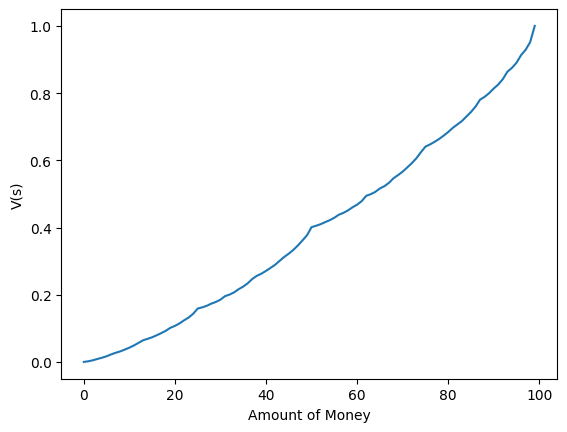
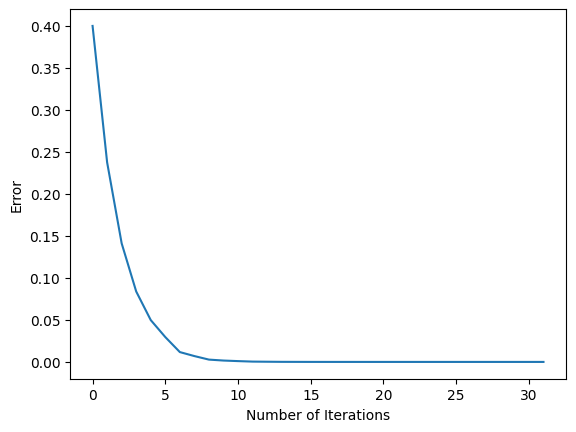
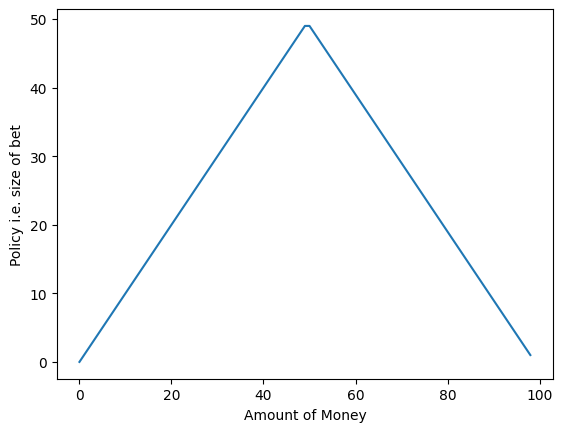

## Put your code and plots in the cell below

# Problem 2: Value and policy iteration in a slightly more complicated
# MDP
For this second problem, you're basically going to be able to reuse the code that you've already written, but I want you to see that it's possible to use the same ideas to solve a more complicated problem.

As discussed in class, we have a two lane intersection controlled by a single traffic light. Traffic flows either South to North or East to West. At every tick, two cars will go through the intersection if the light is green in their direction (if there are fewer than two cars at the intersection, that number will go). After the cars go, with probability $p$ two cars will arrive at the north-south intersection and with probability $1-p$ they'll arrive at the west-east intersection. We receive a reward of +1 for the decrease in the queue size at each intersection.
Each intersection has a maximum queue length of $10$ cars. That is, if there are already $10$ cars in a given queue and another car arrives, the queue length will still be $10$. If a queue has more than $5$ cars, we receive a reward of -1 at each step. So, for example, if the north-south queue has length 6 and the east-west queue has length 4, we'll receive an additional reward of -1. If the north-south queue has length 6 and the east-west queue has length 6, we'll receive a reward of -2.
At each step, we can take an action to either set the traffic light to North or the traffic light to East. 

To make life easier, I've written up this environment for you. Note that in this environment, the state is $[q_0, q_1]$ where $q_0$ is the length of the north-south queue and $q_1$ is the east-west queue. Note that the traffic light direction is not a part of this state; make sure you understand why it isn't needed!`

In [35]:
from copy import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

# some useful constants
NORTH_PROB = 0.7
GAMMA = 0.95
MAX_QUEUE_LENGTH = 10

# make everything deterministic
np.random.seed(0)
random.seed(0)

In [67]:

    
class TrafficLightAction(Enum):
    NORTH = 0
    EAST = 1

class TrafficLightEnv():
    def __init__(self, ns_arrival_prob:float=0.75, max_queue_size:int=10):
        """Initializes the traffic light environment.
        
        Args:
            ns_arrival_prob: the probability of a car arriving from the north or south
            max_queue_size: the maximum number of cars that can be in each queue"""
        self.ns_arrival_prob = ns_arrival_prob
        self.max_queue_size = max_queue_size
        self.traffic_light_state = TrafficLightAction.NORTH.value
        
    def reset(self):
        """Resets the environment to its initial state."""
        return [0, 0]
        
    def step(self, state: np.array, action: int):
        """Takes a step in the environment.
        
        Args:
            state: the current state of the environment
            action: the action to take
        Returns: the new state and the reward"""
        old_state = copy(state)
        q_0, q_1 = state
    
        # Handle car departures based on the current direction
        if action == TrafficLightAction.NORTH.value:
            departed_cars = min(q_0, 2)
            q_0 = max(q_0 - departed_cars, 0)
        else:
            departed_cars = min(q_1, 2)
            q_1 = max(q_1 -departed_cars, 0)
                    
        # Handle car arrivals probabilistically
        if random.random() < self.ns_arrival_prob:
            if q_0 < self.max_queue_size: q_0 += 2
        else:
            if q_1 < self.max_queue_size: q_1 += 2
        
        # Update state after cars arrive
        new_state = np.array([q_0, q_1])
        reward = self.reward(old_state, new_state)
    
        return new_state, reward
        
    def reward(self, curr_state, next_state):
        """The reward is +1 for each departed car, -1 for each queue greater than 5"""
        north_reward = max(curr_state[0] - next_state[0], 0)
        east_reward = max(curr_state[1] - next_state[1], 0)
        north_penalty = -1 if next_state[0] > 5 else 0
        east_penalty = -1 if next_state[1] > 5 else 0
        return north_reward + east_reward + north_penalty + east_penalty
        
# here's a useful utility function
def evaluate_and_plot(policy, env: TrafficLightEnv, episode_length:int=100):
    """Evaluates a policy and plots the results.
    
    Args:
        policy: the policy to evaluate. It should take in a 2-d state and
            return either a 0 or a 1.
        env: the environment to evaluate the policy on
        episode_length: the length of each episode
        
    Returns: the average reward for an episode
    """
    state = env.reset()
    states = np.zeros((episode_length, 2))
    tl_state = np.zeros(episode_length)
    rewards = np.zeros(episode_length)
    for t in range(episode_length):
        action = policy(state)
        assert (action == 0 or action == 1), "Policy should return 0 or 1"
        state, reward = env.step(state, action)
        states[t, 0] = state[0]
        states[t, 1] = state[1]
        tl_state[t] = action
        rewards[t] = (GAMMA**t) * reward
        
    # plot the queues on one plot and then the rewards on another
    # in a grid
    _, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(states[:, 0])
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('North Queue')

    ax[1].plot(states[:, 1])
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('East Queue')
    # ax[0].legend(['Queue 0', 'Queue 1'])

    ax[2].plot(tl_state)
    ax[2].set_xlabel('Time')
    ax[2].set_ylabel('tl state')

    ax[3].plot(rewards.cumsum())
    ax[3].set_xlabel('Time')
    ax[3].set_ylabel('Discounted Reward')
    plt.show()
    print("total reward is ", rewards.sum())
        

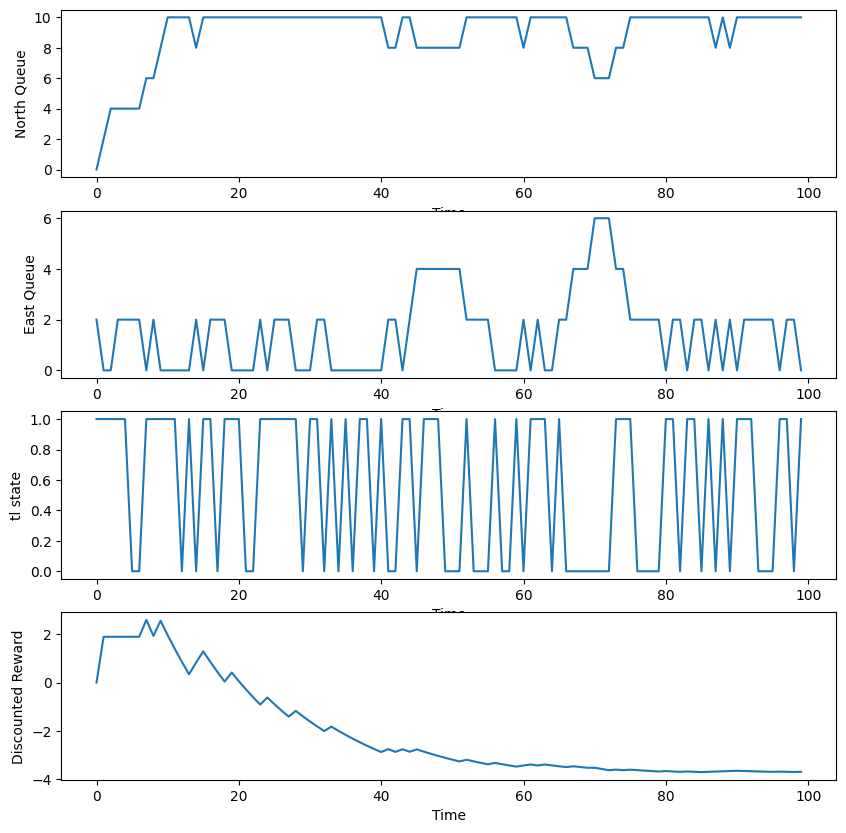

total reward is  -3.7037161444789715


In [68]:
# Lets do a random rollout and visualize the length of each of the queues and the reward
# as a function of time

episode_length = 100
env = TrafficLightEnv(ns_arrival_prob=NORTH_PROB, max_queue_size=MAX_QUEUE_LENGTH)
evaluate_and_plot(lambda x: random.choice([0, 1]), env, episode_length=episode_length)


## Problem 2.1: Try to beat the random policy

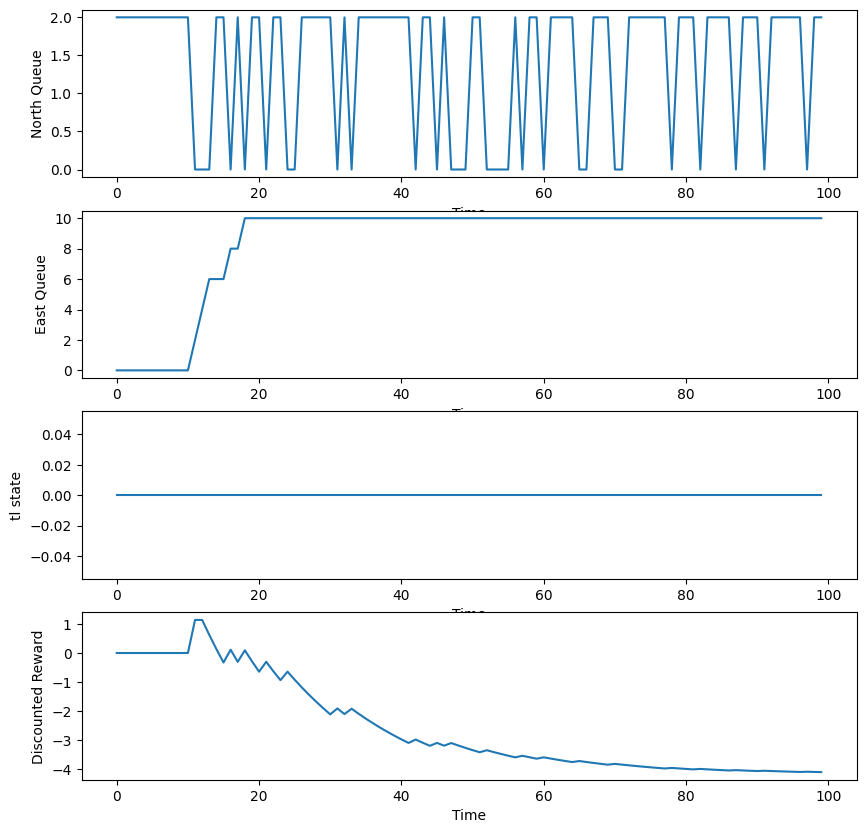

total reward is  -4.097817170211798


In [69]:
# write down a policy that you think is good here! 
def policy(state):
    """Fill in a better policy here"""
    return 0

evaluate_and_plot(policy, env, episode_length=100)

## Problem 2.2: Value iteration

Now lets solve the actual optimal policy using value iteration.

Now, it's pretty annoying to write out the transition probabilities and rewards for this problem, so I've approximately computed them for you below by rolling out the environment for a long time and computing the probability of transitioning from any state to any other state. 
Note that the format of the transition probabilities is as follows:
- The first index is the current north-south queue
- The second index is the current east-west queue
- The third index is the action
- The fourth index is the next state of the north-south queue
- The fifth index is the next state of the east-west queue

It's worth following through the details of what I did below but it's not essential. The important thing to know is that you can index into the matrix to compute the probability of starting with a queue size, taking an action, and transitioning to the new queue size.

In [73]:
# the elements of the transition matrix are the probabilities of transitioning from one state to another
# the transition matrix is a 5-dimensional array, with the first 2 
# dimensions representing the current state
# the 3rd dimension representing the action
# and the last 2 dimensions representing the next state
transition_probs = np.zeros((MAX_QUEUE_LENGTH + 1, 
                             MAX_QUEUE_LENGTH + 1, 
                             2,
                             MAX_QUEUE_LENGTH + 1,
                             MAX_QUEUE_LENGTH + 1))
num_rollouts = 10000
env = TrafficLightEnv(ns_arrival_prob=NORTH_PROB, max_queue_size=MAX_QUEUE_LENGTH)
for i in range(num_rollouts):
    state = env.reset()
    for t in range(100):
        action = random.choice([0, 1])
        new_state, reward = env.step(state, action)
        transition_probs[state[0], state[1], action, 
                         new_state[0], new_state[1]] += 1
        state = new_state
# now we need to normalize the transition probabilities
# normally we would vectorize this but it's clearer to write it out
for q_0 in range(11):
    for q_1 in range(11):
        for action in range(2):
            if transition_probs[q_0, q_1, action].sum() > 0:
                transition_probs[q_0, q_1, action] /= transition_probs[q_0, q_1, action].sum()
                
# a few quick sanity checks to make sure we did the right thing
# first the probability of transitioning from [0, 0] to [0, 0] should be 0
# because a car should always arrive
assert transition_probs[0, 0, 0, 0, 0] == 0
# next, there should be APPROXIMATELY a NORTH_PROB of transitioning from 
# [0, 0] to [2, 0] regardless of the action
# and a 1 - NORTH_PROB probability of transitioning to [0, 2]
print('got ', transition_probs[0, 0, 0, 2, 0], 'expected ', NORTH_PROB)
print('got ', transition_probs[0, 0, 0, 0, 2], 'expected ', 1 - NORTH_PROB)
# finally, if the state is say, [4, 0] and the action is 0 then we should have
# NORTH_PROB probability of transitioning to [3, 0] and a 1 - NORTH_PROB probability
# of transitioning to [2, 1]
# and we can do something similar for the other action
print('got ', transition_probs[4, 0, 0, 4, 0], 'expected ', NORTH_PROB)
print('got ', transition_probs[4, 0, 0, 2, 2], 'expected ', 1 - NORTH_PROB)
print('got ', transition_probs[0, 4, 1, 2, 2], 'expected ', NORTH_PROB)
print('got ', transition_probs[0, 4, 1, 0, 4], 'expected ', 1 - NORTH_PROB)

got  0.6951650943396226 expected  0.7
got  0.30483490566037735 expected  0.30000000000000004
got  0.6890296931295813 expected  0.7
got  0.3109703068704187 expected  0.30000000000000004
got  0.7060314242270653 expected  0.7
got  0.2939685757729346 expected  0.30000000000000004


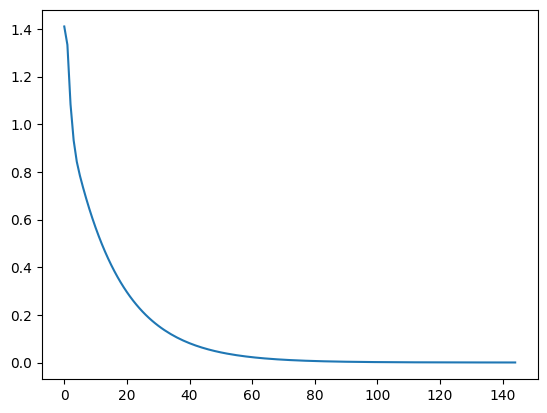

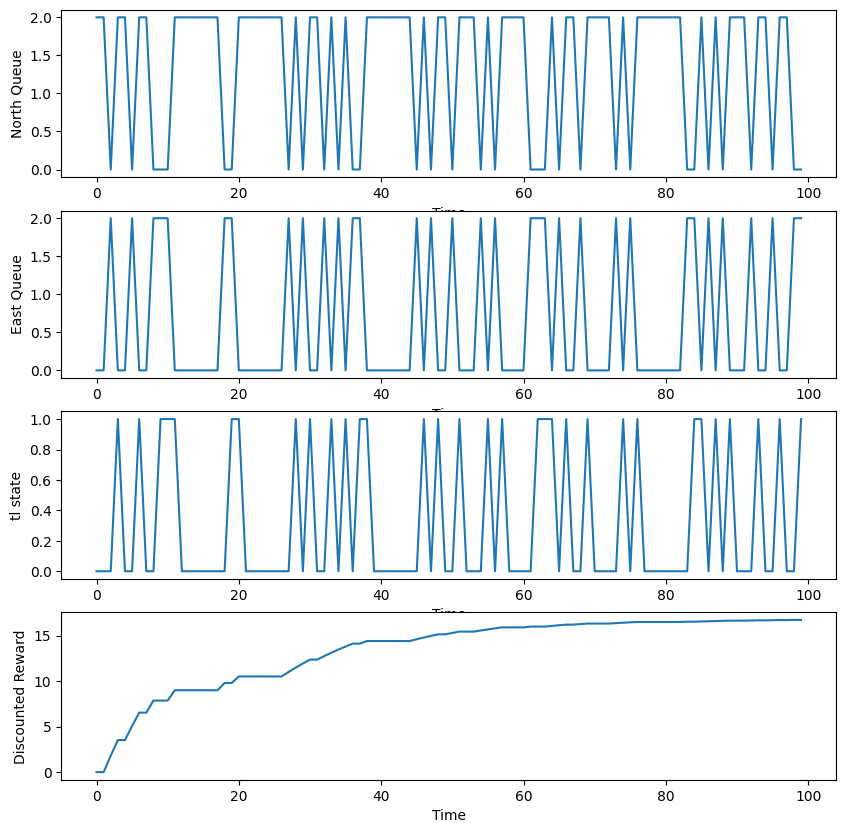

total reward is  16.729389253395055


Text(0, 0.5, 'Queue 1')

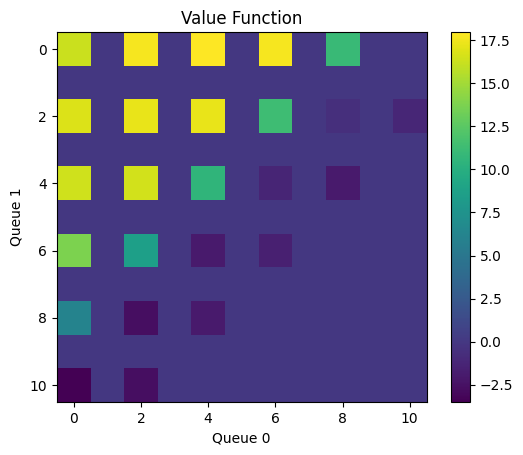

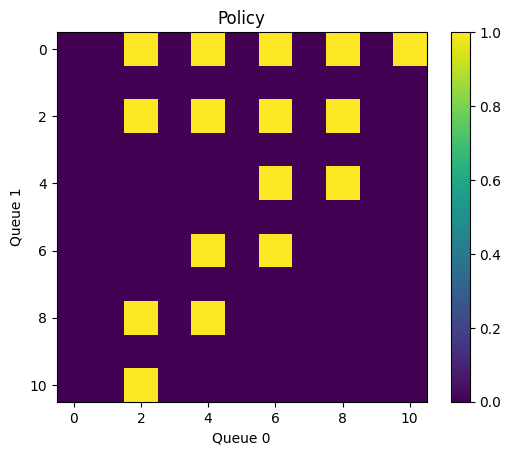

In [72]:
value_guess = np.zeros((MAX_QUEUE_LENGTH + 1, MAX_QUEUE_LENGTH + 1))
policy_guess = np.zeros((MAX_QUEUE_LENGTH + 1, MAX_QUEUE_LENGTH + 1))
epsilon = 0.0001

# PUT YOUR VALUE ITERATION CODE HERE TO UPDATE THE VALUE
# FUNCTION AND POLICY
# note that it will be helpful to use the reward function from the env
# so here's a helpful utility function
def reward(curr_state, next_state):
    return env.reward(curr_state, next_state)

# Also, please plot the size of the size of the maximum change of any entry
# in the value function array as a function of iteration number
max_err = 1e6
error_arr = []
while max_err > epsilon:
    max_err = 0
    for q_0 in range(11):
        for q_1 in range(11):
            old_value = value_guess[q_0, q_1]
            new_value = -1e6
            for action in range(2):
                v = 0
                for next_q_0 in range(11):
                    for next_q_1 in range(11):
                        v += transition_probs[q_0, q_1, action, next_q_0, next_q_1] * \
                            (reward([q_0, q_1], [next_q_0, next_q_1]) \
                                + GAMMA * value_guess[next_q_0, next_q_1])
                if v > new_value:
                    new_value = v
                    policy_guess[q_0, q_1] = action
            value_guess[q_0, q_1] = new_value
            max_err = max(max_err, abs(old_value - new_value))
    error_arr.append(max_err)

plt.figure()
plt.plot(error_arr)

def policy_func(state):
    return policy_guess[state[0], state[1]]

evaluate_and_plot(policy_func, env, episode_length=100)

# lets also make some plots of the policy 
# and the value function. Do they make sense?

plt.figure()
plt.imshow(value_guess)
plt.colorbar()
plt.title('Value Function')
plt.xlabel('Queue 0')
plt.ylabel('Queue 1')

plt.figure()
plt.imshow(policy_guess)
plt.colorbar()
plt.title('Policy')
plt.xlabel('Queue 0')
plt.ylabel('Queue 1')

## Problem 2.3: Policy iteration
Repeat the above problem but use the policy iteration algorithm instead

In [ ]:
value_guess = np.zeros((MAX_QUEUE_LENGTH + 1, MAX_QUEUE_LENGTH + 1))
policy_guess = np.zeros((MAX_QUEUE_LENGTH + 1, MAX_QUEUE_LENGTH + 1))
epsilon = 0.001
def reward(curr_state, next_state):
    return env.reward(curr_state, next_state)

def policy_func(state):
    return policy_guess[state[0], state[1]]

evaluate_and_plot(policy_func, env, episode_length=100)

## Problem 2.4 - Q-learning!
Okay, now we'll learn our first model-free reinforcement learning algorith. We'll use Q-learning to solve the same problem. Rather than requiring the explicit functional form of the transition probabilities 